In [ ]:
import numpy as np
import scipy.sparse as sp

from pathlib import Path
from sklearn.neighbors import kneighbors_graph

import torch
import torch.nn.functional as F
from torch import nn
from torch import optim

from sklearn.metrics import confusion_matrix, normalized_mutual_info_score
from hygem.metric import evaluate_clustering

from hygem.pairs import get_pairs_unique_map

In [ ]:

import numpy as np
import scipy.sparse as sp

from pathlib import Path
from sklearn.neighbors import kneighbors_graph

import torch
import torch.nn.functional as F
from torch import nn
from torch import optim

from sklearn.metrics import confusion_matrix, normalized_mutual_info_score
from hygem.metric import evaluate_clustering

from hygem.pairs import get_pairs_unique_map


datasets_path = Path("/buckets/datasets/repr/")
dataset_name = "cifar100"
model_name = "clipvitL14"
X = np.load(datasets_path / f"{model_name}/{dataset_name}_feats_train.npy")
y = np.load(datasets_path / f"{model_name}/{dataset_name}_y_train.npy")
K = 100

X_val = np.load(datasets_path / f"{model_name}/{dataset_name}_feats_val.npy")
y_val = np.load(datasets_path / f"{model_name}/{dataset_name}_y_val.npy")

distances = kneighbors_graph(X, n_neighbors=500, mode="distance")

X = torch.tensor(X).float().to("cuda:1")
y = torch.tensor(y).int().to("cuda:1")


W = distances + distances.T

W_exp = W/W.data.mean()

W_exp.data = np.exp(-W_exp.data**2)

D = W_exp.sum(axis=0)




KeyboardInterrupt: 

In [ ]:

class ClusterBias(nn.Module):

    def __init__(self, K:int):
        super().__init__()
        self.biases = nn.Parameter(torch.zeros((1, K-1)), requires_grad=True)
    
    def forward(self, Z):
        # biases = F.(self.biases, )
        biases = F.pad(self.biases,(1,0), value=0.0)
        Y_for_Z = Z + biases.detach()
        Y_for_biases = Z + biases
        return Y_for_Z, Y_for_biases


hidden_dim = X.shape[1]
network = nn.Sequential(
    nn.Linear(hidden_dim, 1024),
    nn.SiLU(),
    nn.Linear(1024, 512),
    nn.SiLU(),
    nn.Linear(512, K),
    nn.SiLU(),
    ClusterBias(K)
      )
network = network.to(X)

pairs = np.array(W_exp.nonzero()).T


batch_pair_size = 1024*2






TypeError: to() received an invalid combination of arguments - got (numpy.ndarray), but expected one of:
 * (torch.device device = None, torch.dtype dtype = None, bool non_blocking = False, bool copy = False, *, torch.memory_format memory_format = None)
 * (torch.dtype dtype, bool non_blocking = False, bool copy = False, *, torch.memory_format memory_format = None)
 * (Tensor tensor, bool non_blocking = False, bool copy = False, *, torch.memory_format memory_format = None)


: 

In [ ]:
optimizer = optim.Adam(network.parameters(), lr=1e-3, weight_decay=1e-4)

In [15]:
# optimizer = optim.Adam(network.parameters(), lr=1e-3, weight_decay=1e-4)
# optimizer = optim.SGD(network.parameters(), lr=1e-3, momentum=0.9)

for _ in range(1000):
    random_idx = np.random.choice( X.shape[0], batch_pair_size, replace=False)
    x_batch = X[random_idx]
    _, y_for_bias = network(x_batch)
    p_for_bias = torch.softmax(y_for_bias,dim=-1)
    balance = (p_for_bias.mean(0) - 1 / K).square().sum()
    loss = balance
    optimizer.zero_grad()
    loss.backward()
    # optimizer.step()
    break
    # with torch.no_grad():
        # print(loss.item(), balance.item(), p_for_bias.sum(1).max())
        # print(p_for_bias.mean(0).cpu().numpy())




In [17]:
list(network.parameters())[-1].grad,list(network.parameters())[-1].data

(tensor([[-4.0159e-07, -7.4953e-07,  2.8508e-08,  2.0099e-06, -1.5469e-06,
           1.6572e-06,  1.1597e-06, -1.0074e-06, -1.6587e-06,  5.2759e-07,
           1.6994e-07, -3.7007e-08, -2.8853e-07,  7.4760e-07,  1.3736e-07,
           2.7205e-06, -2.6591e-06,  1.4897e-06,  8.1792e-07,  9.9053e-07,
          -5.5494e-07, -1.3568e-06,  1.1516e-06, -2.4845e-07, -6.8081e-07,
           4.7608e-08,  4.2552e-07,  7.3169e-07,  7.1006e-07,  1.5387e-07,
           4.4459e-07,  1.2193e-06,  2.8056e-06,  1.5949e-06,  1.5788e-06,
           5.2696e-07,  1.7597e-06, -4.6523e-07,  1.3218e-06,  5.2421e-08,
          -4.8450e-07, -9.3744e-07,  3.5370e-06, -3.5712e-06, -6.1093e-07,
          -6.7981e-07, -2.0085e-06,  2.4399e-06,  1.9420e-06, -3.5397e-06,
          -4.2263e-07,  7.1718e-07,  1.1874e-06,  3.3093e-07,  9.9223e-07,
          -1.2506e-06,  3.4129e-07, -2.4592e-06,  4.6595e-07, -3.2000e-06,
           4.7507e-07,  1.6291e-07, -1.8702e-07, -9.2802e-07,  3.0793e-06,
          -2.6019e-06, -4

In [ ]:

pcut_weight=10.0

for _ in range(1000):
    random_pairs_idx = np.random.choice(
        pairs.shape[0], batch_pair_size, replace=False
    )
    batch_pairs = pairs[random_pairs_idx]
    unique_idx, left_idx, right_idx = get_pairs_unique_map(batch_pairs)
    

    w = (
        torch.tensor(W_exp[batch_pairs[:, 0], batch_pairs[:, 1]].toarray())
        .to(X)
    )
    x_batch = X[unique_idx]
    y_batch = y[unique_idx]

    y_for_z, y_for_bias = network(x_batch)
    p_for_z = torch.softmax(y_for_z,dim=-1)
    p_for_bias = torch.softmax(y_for_z,dim=-1)
    
    p_for_z_left = p_for_z[left_idx]
    # [:,None]
    p_for_z_right = p_for_z[right_idx]
    # [None,:]
    pcut = (
        (
            w.unsqueeze(-1)
            # w
            * (
                p_for_z_left * (1 - p_for_z_right)
                + p_for_z_right * (1 - p_for_z_left)
            )
        )
        .sum(-1)
        .mean()
    )
    balance = (p_for_bias.mean(0) - 1 / K).square().mean()

    loss = pcut_weight * pcut + balance*1.e5
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        Z, _ = network(X)
        pred = Z.argmax(dim=-1)
        results = evaluate_clustering(y.cpu().numpy(), pred.cpu().numpy(), K)

        print(loss.item(), pcut.item(), balance.item(),results["accuracy"], results["nmi"])

0.20503467321395874 0.020413637161254883 8.983017885100253e-09 0.01 0.0
0.198989138007164 0.019849874079227448 4.903969230696248e-09 0.01514 0.018988185865378288
0.19791550934314728 0.019779600203037262 1.195041066104352e-09 0.01346 0.012254332477313841
0.2090585082769394 0.02087431587278843 3.1535367650548096e-09 0.01836 0.03125875882970912
0.2121608853340149 0.021199988201260567 1.6100016875242318e-09 0.0167 0.03050678904445296
0.19503965973854065 0.01946970820426941 3.4257117142999505e-09 0.01636 0.02454289409520866
0.20429441332817078 0.020407915115356445 2.1526398441551464e-09 0.01218 0.007735184269629405
0.2044965624809265 0.020444359630346298 5.295883731548656e-10 0.01684 0.026569650050832304
0.19869987666606903 0.019855860620737076 1.4127632397276102e-09 0.02022 0.04053663075625383
0.19623304903507233 0.019619496539235115 3.809424997669453e-10 0.0226 0.04631932605039657
0.20091544091701508 0.02008572593331337 5.819225656900073e-10 0.01608 0.030046937016102546
0.1946633607149124

KeyboardInterrupt: 

In [22]:
p_for_z_left.shape, p_for_z_right.shape

(torch.Size([2048, 1, 100]), torch.Size([1, 2048, 100]))

In [23]:
w.shape

torch.Size([2048, 2048])

(array([4.000e+00, 6.100e+01, 3.690e+02, 8.410e+02, 1.822e+03, 3.386e+03,
        5.057e+03, 6.000e+03, 6.464e+03, 5.836e+03, 4.634e+03, 3.548e+03,
        2.736e+03, 2.205e+03, 1.654e+03, 1.323e+03, 9.790e+02, 7.600e+02,
        6.450e+02, 4.810e+02, 3.520e+02, 2.580e+02, 1.920e+02, 1.410e+02,
        8.900e+01, 7.000e+01, 3.800e+01, 2.300e+01, 1.600e+01, 1.100e+01,
        4.000e+00, 1.000e+00]),
 array([4.52128273, 4.63231985, 4.74335696, 4.85439408, 4.96543119,
        5.07646831, 5.18750542, 5.29854254, 5.40957966, 5.52061677,
        5.63165389, 5.742691  , 5.85372812, 5.96476523, 6.07580235,
        6.18683946, 6.29787658, 6.40891369, 6.51995081, 6.63098792,
        6.74202504, 6.85306215, 6.96409927, 7.07513638, 7.1861735 ,
        7.29721062, 7.40824773, 7.51928485, 7.63032196, 7.74135908,
        7.85239619, 7.96343331, 8.07447042]),
 <BarContainer object of 32 artists>)

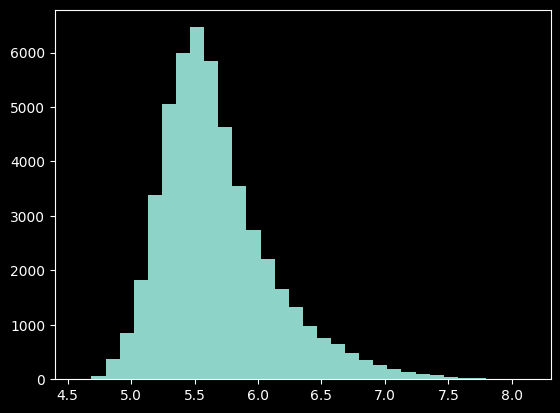

In [3]:
import matplotlib.pyplot as plt
plt.hist(np.log(np.array(D).reshape(-1,)), bins=32,align="right")

In [4]:
def stick_breaking_logits_to_probs_log(Y: torch.Tensor, dim: int = -1) -> torch.Tensor:
    """log-domain stick-breaking: Y (..., K-1) -> P (..., K)."""
    K = Y.size(dim)
    if K < 1:
        raise ValueError("Y must have size >= 1 along `dim`.")
    log_z  = F.logsigmoid(Y)    # log sigma(Y)
    log_1mz = F.logsigmoid(-Y)   # log(1 - sigma(Y)) = log sigma(-Y)
    S = torch.cumsum(log_1mz, dim=dim)
    # Build exclusive prefix of S by padding a zero then dropping the last elem
    zeros_shape = list(Y.shape)
    zeros_shape[dim] = 1
    zeros = torch.zeros(zeros_shape, dtype=Y.dtype, device=Y.device)
    # helper slices
    idx = [slice(None)] * Y.ndim
    idx_last = idx.copy()
    idx_last[dim] = slice(K-1, K)
    idx_up_to = idx.copy()
    idx_up_to[dim] = slice(0, K-1)
    prefix = torch.cat([zeros, S[tuple(idx_up_to)]], dim=dim)
    log_p_except_last = log_z + prefix
    log_p_last = S[tuple(idx_last)]
    return torch.cat([log_p_except_last, log_p_last], dim=dim)

0.020010607317090034 0.020010557025671005 4.9899110621254295e-08 0.0365 0.0919111263378052
0.01952703483402729 0.01952698454260826 4.949199805537319e-08 0.0365 0.0919111263378052
0.02089345082640648 0.02089340053498745 5.010438641761539e-08 0.0365 0.0919111263378052
0.02005428820848465 0.02005423791706562 4.994956626092062e-08 0.0365 0.0919111263378052
0.019124524667859077 0.019124474376440048 4.9847102445710334e-08 0.0365 0.0919111263378052
0.020547328516840935 0.020547278225421906 4.976014622570801e-08 0.0365 0.0919111263378052
0.01951736956834793 0.0195173192769289 4.979271395200158e-08 0.0365 0.0919111263378052
0.02048918604850769 0.02048913575708866 4.993957958276951e-08 0.0365 0.0919111263378052
0.01964649371802807 0.01964644342660904 5.014181425622155e-08 0.0365 0.0919111263378052
0.02001183107495308 0.02001178078353405 4.978772949471022e-08 0.0365 0.0919111263378052
0.0206209234893322 0.02062087319791317 4.9872308949261424e-08 0.0365 0.0919111263378052
0.02029222436249256 0.020

KeyboardInterrupt: 

In [131]:
results = m.evaluate_clustering(y.cpu().numpy(), pred.cpu().numpy(), 10)
results

{'accuracy': 0.699,
 'nmi': 0.7446894450228723,
 'confusion_matrix': array([[2597,    4,    2,  687,    3,    2,    0, 1701,    3,    1],
        [   4, 4111,  773,    0,    0,    0,    0,    1,    3,  108],
        [  98, 1724, 2472,    3,  627,    1,    0,   42,   33,    0],
        [   5,    1,    4, 4943,   18,   24,    0,    3,    2,    0],
        [   0,    0, 1823,    2, 3167,    3,    0,    3,    2,    0],
        [   0,    0,    1,   89,   13, 4894,    0,    3,    0,    0],
        [   1,    0,    2,    5,   38,    1,    0, 2425, 2528,    0],
        [   0,    0,    0,    0,   12,    0,    0, 4988,    0,    0],
        [2189,    2,    0,    0,    0,    0,    0,    1, 2807,    1],
        [   3,   17,    7,    0,    0,    1,    0,    0,    1, 4971]])}

In [114]:

with torch.no_grad():
    Z, _ = network(X)
    # Z = network(X)
    # Z = stick_breaking_logits_to_probs_log(Z)
    pred = Z.argmax(dim=-1)

In [126]:
import importlib
import hygem
import hygem.metric as m
importlib.reload(hygem)
importlib.reload(hygem.metric)
from hygem.metric import evaluate_clustering

In [127]:
unsupervised_accuracy(y.cpu().numpy(), pred.cpu().numpy())

np.float64(0.05696)

In [129]:
m.evaluate_clustering(y.cpu().numpy(), pred.cpu().numpy(), 10)

{'accuracy': 0.699,
 'nmi': 0.7446894450228723,
 'confusion_matrix': array([[2597,    4,    2,  687,    3,    2,    0, 1701,    3,    1],
        [   4, 4111,  773,    0,    0,    0,    0,    1,    3,  108],
        [  98, 1724, 2472,    3,  627,    1,    0,   42,   33,    0],
        [   5,    1,    4, 4943,   18,   24,    0,    3,    2,    0],
        [   0,    0, 1823,    2, 3167,    3,    0,    3,    2,    0],
        [   0,    0,    1,   89,   13, 4894,    0,    3,    0,    0],
        [   1,    0,    2,    5,   38,    1,    0, 2425, 2528,    0],
        [   0,    0,    0,    0,   12,    0,    0, 4988,    0,    0],
        [2189,    2,    0,    0,    0,    0,    0,    1, 2807,    1],
        [   3,   17,    7,    0,    0,    1,    0,    0,    1, 4971]])}

In [63]:
with torch.no_grad():
    Z = network(torch.tensor(X_val).cuda().float())
    pred = Z.argmax(dim=-1)
    score = normalized_mutual_info_score(y_val, pred.cpu().numpy())
    print(loss.item(), pcut.item(), balance.item(), score)

0.0016583704855293036 0.0013042939826846123 0.003540764795616269 0.8882565832473053


In [64]:
from sklearn.cluster import SpectralClustering

In [65]:
cluster = SpectralClustering(n_clusters=10, n_neighbors=500)

In [66]:
cluster.fit(X_val)

/misc/envs/hycut/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
normalized_mutual_info_score(y_val, cluster.predict(X_val))

In [ ]:
random_pairs_idx = np.random.choice(
        pairs.shape[0], batch_pair_size, replace=False
    )
batch_pairs = pairs[random_pairs_idx]
unique_idx, left_idx, right_idx = get_pairs_unique_map(batch_pairs)
y_batch = y[unique_idx]

In [ ]:
batch_pairs.min(), batch_pairs.max()

(np.int32(3), np.int32(49999))

In [ ]:
unique_idx,y[unique_idx]

(array([    3,     4,     5, ..., 49997, 49998, 49999],
       shape=(16173,), dtype=int32),
 tensor([4, 1, 1,  ..., 9, 1, 1], device='cuda:0', dtype=torch.int32))

In [ ]:
y_batch

tensor([4, 1, 1,  ..., 9, 1, 1], device='cuda:0', dtype=torch.int32)

In [ ]:
y[batch_pairs[:,0]],y[batch_pairs[:,1]]

(tensor([3, 3, 5,  ..., 6, 9, 3], device='cuda:0', dtype=torch.int32),
 tensor([3, 3, 5,  ..., 6, 9, 3], device='cuda:0', dtype=torch.int32))

In [ ]:
y[pairs[:,0]] == y[pairs[:,1]]

tensor([ True,  True,  True,  ..., False, False,  True], device='cuda:0')

In [ ]:
y_batch[left_idx],y_batch[right_idx]

(tensor([3, 3, 5,  ..., 6, 9, 3], device='cuda:0', dtype=torch.int32),
 tensor([3, 3, 5,  ..., 6, 9, 3], device='cuda:0', dtype=torch.int32))

In [ ]:
y_batch[left_idx], y_batch[right_idx]

(tensor([3, 3, 5,  ..., 6, 9, 3], device='cuda:0', dtype=torch.int32),
 tensor([3, 3, 5,  ..., 6, 9, 3], device='cuda:0', dtype=torch.int32))

In [ ]:
y

AcceleratorError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
w.shape, w.sum()

(torch.Size([10240]), tensor(10029., device='cuda:0'))

In [ ]:
y

In [ ]:
from sklearn.metrics import confusion_matrix, normalized_mutual_info_score

with torch.no_grad():
    Z = network(X)
    Z = stick_breaking_logits_to_probs_log(Z)
pred = Z.argmax(dim=-1)


In [ ]:
confusion_matrix(y.cpu(), pred.cpu().numpy())

array([[4759,  196,   31,   14,    0,    0,    0,    0,    0,    0],
       [3299, 1376,  289,   35,    1,    0,    0,    0,    0,    0],
       [4837,  133,   25,    2,    3,    0,    0,    0,    0,    0],
       [4663,  337,    0,    0,    0,    0,    0,    0,    0,    0],
       [4931,   68,    0,    1,    0,    0,    0,    0,    0,    0],
       [4734,  248,   16,    1,    1,    0,    0,    0,    0,    0],
       [4775,  225,    0,    0,    0,    0,    0,    0,    0,    0],
       [4619,  217,  163,    1,    0,    0,    0,    0,    0,    0],
       [3438,  930,  573,   59,    0,    0,    0,    0,    0,    0],
       [4460,  253,   38,  249,    0,    0,    0,    0,    0,    0]])

In [ ]:
Z.exp().sum(1)

tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000], device='cuda:0')

In [ ]:
pred.cpu()

tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')

In [ ]:
pcut

tensor(0.2866, device='cuda:0', grad_fn=<SumBackward1>)

In [ ]:
pcut.shape

torch.Size([1024, 10])

In [ ]:
pcut.shape

torch.Size([1, 1024, 10])

In [ ]:
p_for_z.sum(1)

tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000], device='cuda:0',
       grad_fn=<SumBackward1>)

In [ ]:
w

tensor([[0.1312, 0.6018, 0.1312,  ..., 0.6018, 0.6018, 0.6018]],
       device='cuda:0')

In [ ]:
batch_pairs

array([[28228,  1491],
       [ 2996,  7972],
       [ 9115, 46629],
       ...,
       [11842, 47476],
       [18027,  9631],
       [10510, 49431]], shape=(1024, 2), dtype=int32)

In [ ]:
unique_idx

array([   28,    42,    82, ..., 49958, 49982, 49992],
      shape=(2003,), dtype=int32)

In [ ]:
W_exp[batch_pairs]

IndexError: Only 1D or 2D arrays allowed. Index makes 3D

In [ ]:
w

tensor([[1., 2., 1.,  ..., 1., 2., 1.]], device='cuda:0')

In [ ]:
W_exp.nonzero()

(array([    0,     0,     0, ..., 49999, 49999, 49999],
       shape=(35630788,), dtype=int32),
 array([49741, 49623, 48940, ..., 10387, 29469, 22054],
       shape=(35630788,), dtype=int32))

In [ ]:
pairs

array([[    0,     0,     0, ..., 49999, 49999, 49999],
       [49741, 49623, 48940, ..., 10387, 29469, 22054]],
      shape=(2, 35630788), dtype=int32)

In [ ]:
B, K = 2048, 1000
# Y has K-1 logits per row
Y = torch.randn(B, K-1).cuda().requires_grad_()
    #  ).requires_grad_()

In [ ]:
cluster_bias = ClusterBias(K).to(Y.device)

In [ ]:
from torch.optim import SGD,Adam
# optimizer = SGD(cluster_bias.parameters(), momentum=0.9, lr=1e-1)
optimizer = Adam(cluster_bias.parameters(), lr=1e-2)

In [ ]:
for _ in range(10000):
    Y_b = cluster_bias(Y)[1]
    log_P = stick_breaking_logits_to_probs_log(Y_b)
    P_mean = log_P.exp().mean(0)
    loss = (P_mean-1/K).square().sum()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(loss.item())


0.023542270064353943
0.02351594902575016
0.023492028936743736
0.023470183834433556
0.02344970963895321
0.02342993952333927
0.02341054566204548
0.02339143492281437
0.023372629657387733
0.02335413359105587
0.023335913196206093
0.02331787906587124
0.023299958556890488
0.02328210510313511
0.023264305666089058
0.023246560245752335
0.02322886697947979
0.023211220279335976
0.023193595930933952
0.023175975307822227
0.02315833792090416
0.0231406819075346
0.02312300354242325
0.023105300962924957
0.02308756671845913
0.02306978590786457
0.023051947355270386
0.02303403615951538
0.023016048595309258
0.022997979074716568
0.022979823872447014
0.022961584851145744
0.022943247109651566
0.02292480692267418
0.022906258702278137
0.022887596860527992
0.02286881022155285
0.022849896922707558
0.022830858826637268
0.022811682894825935
0.02279236540198326
0.022772900760173798
0.022753283381462097
0.02273351326584816
0.02271358110010624
0.022693483158946037
0.022673213854432106
0.022652769461274147
0.02263214066

In [ ]:
Y_b = cluster_bias(Y)[1]
log_P = stick_breaking_logits_to_probs_log(Y_b)
P_mean = log_P.exp().mean(0)

In [ ]:
log_P.exp().mean(0)

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 

In [ ]:
P_mean

tensor([6.6773e-03, 6.6869e-03, 6.4654e-03, 6.5615e-03, 6.4289e-03, 6.4558e-03,
        6.4039e-03, 6.4839e-03, 6.0220e-03, 6.0237e-03, 5.9016e-03, 6.2836e-03,
        5.8492e-03, 5.9830e-03, 5.8651e-03, 6.0562e-03, 6.0659e-03, 6.0674e-03,
        5.5685e-03, 6.0269e-03, 5.8398e-03, 5.9074e-03, 5.9047e-03, 5.7026e-03,
        5.4781e-03, 5.6557e-03, 5.5631e-03, 5.5110e-03, 5.4084e-03, 5.3760e-03,
        5.3539e-03, 5.5415e-03, 5.4472e-03, 5.4163e-03, 5.3812e-03, 5.4060e-03,
        5.0585e-03, 5.0195e-03, 5.1037e-03, 5.1685e-03, 5.2355e-03, 5.0099e-03,
        4.7240e-03, 4.9945e-03, 4.8415e-03, 4.9972e-03, 4.8126e-03, 5.0440e-03,
        4.6495e-03, 4.7577e-03, 4.7904e-03, 4.9564e-03, 4.6632e-03, 4.8112e-03,
        4.4661e-03, 4.6700e-03, 4.5538e-03, 4.7001e-03, 4.4354e-03, 4.3799e-03,
        4.5003e-03, 4.2769e-03, 4.2720e-03, 4.2682e-03, 4.4404e-03, 4.3133e-03,
        4.5014e-03, 4.2007e-03, 4.1510e-03, 4.2065e-03, 4.2239e-03, 4.0290e-03,
        4.0361e-03, 4.0035e-03, 4.1059e-

In [ ]:
cluster_bias.biases.grad

tensor([[ 8.8614e-05,  8.9334e-05,  8.1186e-05,  8.5819e-05,  8.0959e-05,
          8.2975e-05,  8.1217e-05,  8.4890e-05,  6.8494e-05,  6.8903e-05,
          6.5254e-05,  7.9419e-05,  6.4274e-05,  6.9482e-05,  6.5675e-05,
          7.2829e-05,  7.3415e-05,  7.4227e-05,  5.7654e-05,  7.3496e-05,
          6.7554e-05,  7.0364e-05,  7.0738e-05,  6.4150e-05,  5.7273e-05,
          6.3305e-05,  6.0528e-05,  5.9403e-05,  5.6638e-05,  5.5917e-05,
          5.5690e-05,  6.1959e-05,  5.9119e-05,  5.8776e-05,  5.8070e-05,
          5.9132e-05,  4.8984e-05,  4.8069e-05,  5.0812e-05,  5.3129e-05,
          5.5333e-05,  4.9068e-05,  4.1129e-05,  4.9188e-05,  4.5184e-05,
          4.9919e-05,  4.4912e-05,  5.1966e-05,  4.1025e-05,  4.4236e-05,
          4.5345e-05,  5.0606e-05,  4.2642e-05,  4.7077e-05,  3.7851e-05,
          4.3621e-05,  4.0651e-05,  4.4980e-05,  3.8014e-05,  3.6982e-05,
          4.0353e-05,  3.4797e-05,  3.4804e-05,  3.5066e-05,  3.9620e-05,
          3.6532e-05,  4.1845e-05,  3.

In [ ]:
loss

tensor(0.0023, device='cuda:0', grad_fn=<SumBackward0>)

In [ ]:
P.exp().sum(0)

tensor([13.6809, 13.7006, 13.2463, 13.4435, 13.1714, 13.2267, 13.1202, 13.2843,
        12.3369, 12.3404, 12.0900, 12.8734, 11.9825, 12.2569, 12.0151, 12.4069,
        12.4270, 12.4300, 11.4070, 12.3469, 11.9633, 12.1019, 12.0964, 11.6819,
        11.2216, 11.5858, 11.3959, 11.2890, 11.0786, 11.0123, 10.9669, 11.3516,
        11.1583, 11.0949, 11.0230, 11.0739, 10.3615, 10.2816, 10.4542, 10.5870,
        10.7242, 10.2617,  9.6759, 10.2303,  9.9166, 10.2358,  9.8574, 10.3318,
         9.5232,  9.7448,  9.8118, 10.1522,  9.5512,  9.8545,  9.1473,  9.5651,
         9.3270,  9.6269,  9.0843,  8.9706,  9.2173,  8.7596,  8.7494,  8.7417,
         9.0946,  8.8341,  9.2195,  8.6035,  8.5015,  8.6152,  8.6509,  8.2517,
         8.2661,  8.1992,  8.4092,  7.9715,  8.2107,  8.3632,  7.5911,  8.3595,
         7.8938,  8.2985,  8.0463,  7.5866,  8.0583,  7.5091,  7.5808,  7.6307,
         7.5047,  7.4381,  7.2042,  7.3583,  7.5154,  6.9463,  7.4671,  7.5594,
         7.2570,  7.3223,  6.6874,  6.82

In [ ]:
print(X.shape, y.shape)

(50000, 1536) (50000,)


In [ ]:
slice(0,5,2)

slice(0, 5, 2)

In [ ]:
B, K = 2048, 1000
# Y has K-1 logits per row
Y = (torch.randn(B, K-1).cuda()-5.5).requires_grad_()

# P = stick_breaking_logits_to_probs(Y)      # (B, K), rows sum ≈ 1
P = stick_breaking_logits_to_probs_log(Y)      # (B, K), rows sum ≈ 1
assert torch.allclose(P.exp().sum(-1), torch.ones(B).cuda(), atol=1e-6)

In [ ]:

P = stick_breaking_logits_to_probs_log_fast(Y)      # (B, K), rows sum ≈ 1
assert torch.allclose(P.exp().sum(-1), torch.ones(B).cuda(), atol=1e-6)

In [ ]:
%%timeit
P = stick_breaking_logits_to_probs_log_fast(Y)

187 μs ± 10 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
compiled = torch.compile(stick_breaking_logits_to_probs_log_fast)

In [ ]:
%%timeit
P = compiled(Y)

91.3 μs ± 30.8 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
P.exp().sum(-1)

tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000], device='cuda:0',
       grad_fn=<SumBackward1>)

In [ ]:
P.shape

torch.Size([2048, 999])

In [ ]:
Y = (torch.randn(B, K-1).cuda()-5.5).requires_grad_()

In [ ]:
%%timeit
# Y = (torch.randn(B, K-1).cuda()-5.5).requires_grad_()
P = stick_breaking_logits_to_probs_log(Y)

204 μs ± 20.1 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
compiled = torch.compile(stick_breaking_logits_to_probs_log)

In [ ]:
%%timeit
# Y = (torch.randn(B, K-1).cuda()-5.5).requires_grad_()
P = compiled(Y)

70.4 μs ± 848 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
Y[0]

tensor([-8.8999, -5.5392, -3.9798, -6.0038, -7.4970, -6.3091, -4.2855, -5.2795,
        -5.0119, -5.7284, -5.9704, -6.0929, -5.1994, -5.3037, -6.3682, -5.4405,
        -5.4652, -4.8498, -6.1754, -5.1312, -4.7572, -4.7181, -6.0123, -4.7071,
        -6.1440, -5.6187, -5.6630, -6.8624, -5.3975, -6.7973, -6.6394, -6.1830,
        -6.8131, -7.4388, -4.8073, -7.2689, -4.2485, -4.1768, -5.6676, -5.4064,
        -5.6365, -6.0353, -6.5553, -6.2187, -4.5572, -7.6675, -4.7806, -5.2362,
        -6.5065, -6.1798, -6.9702, -5.7563, -5.6396, -5.5396, -3.6135, -2.9481,
        -6.0043, -4.1889, -6.4532, -5.8503, -5.1953, -6.6456, -4.3922, -4.4864,
        -6.6248, -5.0964, -3.5064, -7.9629, -6.2425, -3.1783, -4.5674, -3.8521,
        -6.4924, -5.6277, -3.7804, -5.5527, -6.8508, -3.7524, -5.9884, -5.4067,
        -5.7375, -6.8154, -5.6259, -4.6867, -6.0767, -5.4985, -6.1391, -4.2959,
        -6.7619, -7.5721, -6.5256, -5.8393, -4.1847, -5.3118, -6.0223, -6.4260,
        -5.9238, -5.2104, -6.3395, -4.83

In [ ]:
P[0]

tensor([1.3639e-04, 3.9138e-03, 1.8272e-02, 2.4084e-03, 5.4072e-04, 1.7705e-03,
        1.3213e-02, 4.8649e-03, 6.3155e-03, 3.0750e-03, 2.4078e-03, 2.1254e-03,
        5.1653e-03, 4.6306e-03, 1.5944e-03, 4.0142e-03, 3.9001e-03, 7.1601e-03,
        1.8982e-03, 5.3611e-03, 7.7263e-03, 7.9631e-03, 2.1776e-03, 7.9598e-03,
        1.8877e-03, 3.1804e-03, 3.0322e-03, 9.1285e-04, 3.9323e-03, 9.6879e-04,
        1.1330e-03, 1.7846e-03, 9.4938e-04, 5.0752e-04, 6.9944e-03, 5.9619e-04,
        1.2049e-02, 1.2750e-02, 2.8612e-03, 3.6988e-03, 2.9280e-03, 1.9603e-03,
        1.1638e-03, 1.6263e-03, 8.4773e-03, 3.7781e-04, 6.7202e-03, 4.2389e-03,
        1.1883e-03, 1.6439e-03, 7.4510e-04, 2.5004e-03, 2.8000e-03, 3.0826e-03,
        2.0598e-02, 3.8074e-02, 1.7876e-03, 1.0817e-02, 1.1222e-03, 2.0449e-03,
        3.9150e-03, 9.1685e-04, 8.6219e-03, 7.7599e-03, 9.1320e-04, 4.1848e-03,
        1.9924e-02, 2.3110e-04, 1.2885e-03, 2.6494e-02, 6.5370e-03, 1.3089e-02,
        9.3234e-04, 2.2058e-03, 1.3679e-

In [ ]:
import matplotlib.pyplot as plt

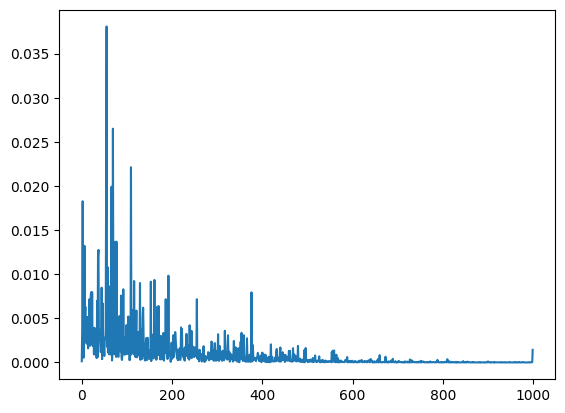

In [ ]:
plt.plot(P[0].detach().numpy())

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
reg = LogisticRegression()

In [ ]:
reg.fit(X.cpu().numpy(), y.cpu().numpy())

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [ ]:
normalized_mutual_info_score(y.cpu().numpy(), reg.predict(X.cpu().numpy()))

0.9999173347102615

In [ ]:
normalized_mutual_info_score(y_val, reg.predict(X_val))

0.9805959205564206

In [35]:
from sklearn.metrics import normalized_mutual_info_score

In [36]:
import numpy as np
import torch
from torch.autograd import Function
from typing import Tuple
from scipy.special import hyp2f1 as sp_hyp2f1  # SciPy exact/analytic continuation

# Small numerical guards
_EPS_Z = 1e-12     # keep z away from {0,1} if you know you stay in that domain
_DTYPE = torch.float32

def _to_numpy(x: torch.Tensor) -> np.ndarray:
    return x.detach().cpu().to(_DTYPE).numpy()

def _from_numpy(x: np.ndarray, device: torch.device) -> torch.Tensor:
    return torch.from_numpy(np.ascontiguousarray(x)).to(device=device, dtype=_DTYPE)

class Hyp2F1(Function):
    """
    Torch autograd wrapper for SciPy's 2F1(a,b;c;z).
    - Gradients are implemented w.r.t. z only:
        d/dz 2F1(a,b;c;z) = (a*b/c) * 2F1(a+1, b+1; c+1; z)
    - If any of a,b,c require grad, we raise (to avoid silent wrong grads).
    - Works with broadcasting across a,b,c,z.
    - Runs SciPy on CPU; safely moves tensors between devices.
    """
    @staticmethod
    def forward(ctx, a: torch.Tensor, b: torch.Tensor, c: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        # Guard: do not allow grads for a,b,c (unsupported)
        if a.requires_grad or b.requires_grad or c.requires_grad:
            raise RuntimeError("Hyp2F1 backward supports gradients w.r.t. z only (a,b,c must not require grad).")

        # Save for backward
        ctx.save_for_backward(a.detach(), b.detach(), c.detach(), z.detach())

        # Move to numpy CPU and broadcast
        a_np, b_np, c_np, z_np = map(_to_numpy, (a, b, c, z))
        a_np, b_np, c_np, z_np = np.broadcast_arrays(a_np, b_np, c_np, z_np)

        # Optional: clamp z away from known branch cut endpoints (helps in practice)
        z_np = np.clip(z_np, -1.0 + _EPS_Z, 1.0 - _EPS_Z)

        # Evaluate SciPy hypergeometric 2F1
        with np.errstate(over='raise', under='ignore', invalid='raise'):
            out_np = sp_hyp2f1(a_np, b_np, c_np, z_np)

        out = _from_numpy(out_np, z.device)
        return out

    @staticmethod
    def backward(ctx, grad_out: torch.Tensor) -> Tuple[torch.Tensor, ...]:
        (a, b, c, z) = ctx.saved_tensors
        device = z.device

        # Convert to numpy
        a_np, b_np, c_np, z_np = map(_to_numpy, (a, b, c, z))
        a1, b1, c1 = a_np + 1.0, b_np + 1.0, c_np + 1.0
        z_np = np.clip(z_np, -1.0 + _EPS_Z, 1.0 - _EPS_Z)

        # dF/dz = (a*b/c) * 2F1(a+1,b+1;c+1;z)
        with np.errstate(over='raise', under='ignore', invalid='raise'):
            Fp_np = sp_hyp2f1(a1, b1, c1, z_np)
        pref = (a_np * b_np) / c_np
        dF_dz_np = pref * Fp_np

        dF_dz = _from_numpy(dF_dz_np, device)
        grad_z = grad_out.to(_DTYPE) * dF_dz

        # No grads for a,b,c (return zeros). Must match number of inputs.
        grad_a = torch.zeros_like(a, dtype=_DTYPE)
        grad_b = torch.zeros_like(b, dtype=_DTYPE)
        grad_c = torch.zeros_like(c, dtype=_DTYPE)
        return grad_a, grad_b, grad_c, grad_z

def hyp2f1(a: torch.Tensor, b: torch.Tensor, c: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
    """
    Public wrapper. Works with broadcasting. Only z may require grad.
    """
    return Hyp2F1.apply(a, b, c, z)

In [37]:
# primitives.py
import torch

def H_b(q: float, b: float, pbar: torch.Tensor, m: int) -> torch.Tensor:
    """
    H_b(q; p̄, m) = (1/q) * 2F1(-m, 1; q/b + 1; p̄)
    """
    device = pbar.device
    a = torch.as_tensor(float(-m),     device=device, dtype=_DTYPE)
    bb= torch.as_tensor(1.0,           device=device, dtype=_DTYPE)
    c = torch.as_tensor((q / b) + 1.0, device=device, dtype=_DTYPE)
    q_tensor = torch.as_tensor(q,      device=device, dtype=_DTYPE)
    return hyp2f1(a, bb, c, pbar.to(_DTYPE)) / q_tensor

def A_b(q: float, b: float, pbar: torch.Tensor, m: int) -> torch.Tensor:
    """
    A_b(q; p̄, m) = H_b(q) - 2 H_b(q+b) + H_b(q+2b)
    """
    Hb0 = H_b(q,         b, pbar, m)
    Hb1 = H_b(q + b,     b, pbar, m)
    Hb2 = H_b(q + 2 * b, b, pbar, m)
    return Hb0 - 2.0 * Hb1 + Hb2

In [38]:
import torch
from torch import Tensor


@torch.no_grad()
def _check_params(q: float, b: float):
    assert q > 0 and b > 0, "q>0 and b>0 required by the envelope"


def prob_cut_upper_and_gap(
    p: Tensor,p_left, p_right,w, q: float = 2.0, b: float = 1.0, zero_aware: bool = True
):
    """
    Given P (batch_size x K), return:
      sum_logU:  sum_ℓ log U_ℓ(P)  (single-bin specialization)
      Gamma:     sum_ℓ Γ_ℓ(P)      (binwise gap; single bin)
    Both in float64 for stability, grads propagate to p via autograd.
    """
    _check_params(q, b)
    p = p.to(torch.float64)
    B, K = p.shape
    # m = B  # single-bin specialization over the minibatch
    m = 1024

    # per-cluster mean p̄_ℓ
    pbar = p.mean(dim=0)  # [K]

    # log U_ℓ = -log q + log 2F1(-m,1; q/b+1; p̄_ℓ)
    c = (q / b) + 1.0
    twof1 = hyp2f1(
        torch.as_tensor(-float(m)).to(p),
        torch.as_tensor(1.0).to(p),
        torch.as_tensor(c, device=p.device),
        pbar,
    )
    # [K]
    # print(pbar, c, m)
    # print(twof1)

    # logU = -torch.log(
    #     torch.as_tensor(q, dtype=torch.float64, device=p.device)
    # ) + torch.log(twof1) + torch.log()
    U = (twof1 * (w.unsqueeze(-1)*p_left*(1-p_right)).mean(0)).sum()
    # sum_logU = logU.sum()  
    sum_logU = U.log()  -torch.log(
        torch.as_tensor(q, dtype=torch.float64, device=p.device))


    # Γ_ℓ = (m/2) * Var * A_b(q; p̄,m) ; with zero-aware variant if requested
    if zero_aware:
        # ω0(x)=x ;  Ω_ℓ = Σ_i p_{iℓ};  μ_ℓ = (Σ_i p_{iℓ}^2)/Ω_ℓ
        Omega = p.sum(dim=0).clamp_min(1e-12)  # [K]
        mu = p.pow(2).sum(dim=0) / Omega  # [K]
        # Var_ω0,ℓ = (1/Ω) Σ_i p_{iℓ}(p_{iℓ}-μ_ℓ)^2
        var = (p * (p - mu).pow(2)).sum(dim=0) / Omega  # [K]
    else:
        # plain within-bin variance over the minibatch
        var = p.var(dim=0, unbiased=False)  # [K]

    Ab = A_b(q, b, pbar, m)  # [K]
    Gamma = (0.5 * m) * (var * Ab).sum()

    return sum_logU, Gamma

In [39]:
rho = 1000.        # gap weight; tune 0.05–0.5
q   = 2.0        # envelope parameter (>0)
b   = 1.0        # exponent; b=1 corresponds to the Ratio-Cut specialization

for _ in range(1000):
    random_pairs_idx = np.random.choice(pairs.shape[0], batch_pair_size, replace=False)

    batch_pairs = pairs[random_pairs_idx]
    unique_idx, left_idx, right_idx = get_pairs_unique_map(batch_pairs)

    x_batch = X[unique_idx].contiguous()
    y_batch = y[unique_idx]  # labels only used for monitoring in your printout

    # y_for_z, y_for_bias = network(x_batch)                 # we only need the stick-breaking head
    y_for_z = network(x_batch)                 # we only need the stick-breaking head
    # y_for_bias = y_for_z
    # p_for_bias = stick_breaking_logits_to_probs_log(y_for_bias).exp()
    # logp = stick_breaking_logits_to_probs_log(y_for_z)
    logp = F.log_softmax(y_for_z,dim=-1)
    p    = logp.exp()                             # [B,K], row-stochastic
    w = (y_batch[left_idx] == y_batch[right_idx]).float().to(x_batch)

    # === Paper-justified objective: J_rho = U + rho * Gamma ===
    sum_logU, Gamma = prob_cut_upper_and_gap(p,p[left_idx], p[right_idx],w, q=q, b=b, zero_aware=True)

    # balance = (p_for_bias.mean(0) - 1 / K).square().sum()
    #  + ( p.mean(0) - 1 / K).square().sum()
    # balance = ( p.mean(0) - 1 / K).square().sum()
    # balance=0.
    loss = sum_logU + rho * Gamma 
    # + balance

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        # Z,_ = network(X)
        Z = network(X)
        Z = stick_breaking_logits_to_probs_log(Z)
        pred = Z.argmax(dim=-1)
        score = normalized_mutual_info_score(y.cpu(), pred.cpu().numpy())
        print(
            f"logU={sum_logU.item():.4g} | Gamma={Gamma.item():.4g} | "
            f"J_rho={loss.item():.4g} | NMI={score:.4f}"
            , balance.item()
        )

logU=-2.507 | Gamma=4.462e-05 | J_rho=-2.462 | NMI=0.0000 nan
logU=-2.513 | Gamma=2.371e-05 | J_rho=-2.489 | NMI=0.0000 nan
logU=-2.513 | Gamma=1.028e-05 | J_rho=-2.503 | NMI=0.0000 nan
logU=-2.515 | Gamma=6.042e-06 | J_rho=-2.509 | NMI=0.0000 nan
logU=-2.511 | Gamma=3.901e-06 | J_rho=-2.507 | NMI=0.0000 nan
logU=-2.512 | Gamma=2.703e-06 | J_rho=-2.509 | NMI=0.0000 nan


KeyboardInterrupt: 